In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Baseline Model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,plot_confusion_matrix,plot_roc_curve,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn import decomposition, datasets
from sklearn import tree

In [3]:
final_dataset = pd.read_csv('final_dataset.csv')

In [4]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50242 entries, 0 to 50241
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         50242 non-null  int64 
 1   most_recent         50242 non-null  object
 2   payment_method      50242 non-null  object
 3   payment_status      50242 non-null  object
 4   promo_amount        50242 non-null  int64 
 5   monetary            50242 non-null  int64 
 6   quantity            50242 non-null  int64 
 7   recency             50242 non-null  int64 
 8   frequency           50242 non-null  int64 
 9   transaction_amount  50242 non-null  int64 
 10  is_churn            50242 non-null  bool  
 11  age                 50242 non-null  int64 
 12  promo_amount_used   50242 non-null  int64 
 13  total_amount_paid   50242 non-null  int64 
dtypes: bool(1), int64(10), object(3)
memory usage: 5.0+ MB


In [5]:
# dataset2 = final_dataset[['customer_id', 'payment_method', 'payment_status', 'promo_amount', 'quantity', 'age', 'is_churn']]
# dataset2 

In [6]:
from sklearn.preprocessing import LabelEncoder
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [7]:
final_dataset = final_dataset.apply(lambda x: object_to_int(x))
final_dataset.head()

,customer_id,most_recent,payment_method,payment_status,promo_amount,monetary,quantity,recency,frequency,transaction_amount,is_churn,age,promo_amount_used,total_amount_paid
0,3,26,0,0,8073,826597,5,30,69,1,False,36,3,3
1,8,56,0,0,7699,223431,1,61,8,1,False,22,3,1
2,9,60,2,0,0,643165,1,61,8,2,False,16,1,3
3,11,69,4,0,9492,197533,1,122,1,1,False,29,3,1
4,15,39,3,0,0,1078094,1,181,9,5,False,39,1,4


In [8]:
labelencoder = LabelEncoder()
final_dataset['is_churn'] = labelencoder.fit_transform(final_dataset['is_churn'])
final_dataset['is_churn'].unique()

array([0, 1], dtype=int64)

In [9]:
final_dataset = final_dataset.apply(lambda x: object_to_int(x))
final_dataset.head()

,customer_id,most_recent,payment_method,payment_status,promo_amount,monetary,quantity,recency,frequency,transaction_amount,is_churn,age,promo_amount_used,total_amount_paid
0,3,26,0,0,8073,826597,5,30,69,1,0,36,3,3
1,8,56,0,0,7699,223431,1,61,8,1,0,22,3,1
2,9,60,2,0,0,643165,1,61,8,2,0,16,1,3
3,11,69,4,0,9492,197533,1,122,1,1,0,29,3,1
4,15,39,3,0,0,1078094,1,181,9,5,0,39,1,4


In [10]:
labelencoder = LabelEncoder()
final_dataset['is_churn'] = labelencoder.fit_transform(final_dataset['is_churn'])
final_dataset['is_churn'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:ylabel='is_churn'>

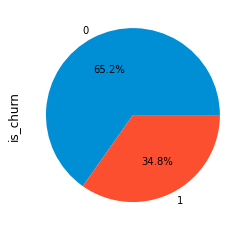

In [11]:
final_dataset['is_churn'].value_counts().plot.pie(autopct='%1.1f%%')

# Feature Selection

In [12]:
X = final_dataset[['customer_id', 'most_recent', 'payment_method', 'payment_status', 'promo_amount', 'monetary', 
                   'quantity', 'recency', 'frequency', 'transaction_amount', 'age', 'promo_amount_used', 'total_amount_paid']]
y = final_dataset[["is_churn"]]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)
print("Jumlah data training: ", X_train.shape)
print("Jumlah data testing: ", X_test.shape)

Jumlah data training:  (35169, 13)
Jumlah data testing:  (15073, 13)


In [14]:
def calc_iv(df, feature, target, pr=False):
    
    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [15]:
iv_df = X_train.copy()
iv_df["target"] = y_train

features = iv_df.columns[:-1].tolist()

iv_list = []
for feature in features:
    iv, data = calc_iv(iv_df, feature, 'target')
    iv_list.append(round(iv,6))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]), 
                      columns=['Feature', 'iv'])
woe_df

,Feature,iv
0,customer_id,0.0
1,most_recent,0.348774
2,payment_method,0.001303
3,payment_status,0.0
4,promo_amount,0.110873
5,monetary,0.015222
6,quantity,0.002722
7,recency,0.352014
8,frequency,2.379952
9,transaction_amount,0.002525


## Logistic Regression

In [63]:
X = final_dataset[['customer_id', 'most_recent', 'payment_method', 'payment_status', 'promo_amount', 'monetary', 
                 'quantity', 'frequency', 'transaction_amount', 'age', 'promo_amount_used', 'total_amount_paid']]
y = final_dataset['is_churn']
# X = dataset2[['customer_id', 'payment_method', 'payment_status', 'promo_amount', 
#                  'quantity', 'age']]
# y = dataset2['is_churn']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)

In [65]:
clf = LogisticRegression()

In [66]:
clf.fit(X_train, y_train)

LogisticRegression()

In [67]:
y_pred = clf.predict(X_test)

In [68]:
clf.score(X_test, y_test)

0.7644795329396935

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84     11988
           1       0.46      0.77      0.57      3085

    accuracy                           0.76     15073
   macro avg       0.69      0.77      0.70     15073
weighted avg       0.83      0.76      0.78     15073



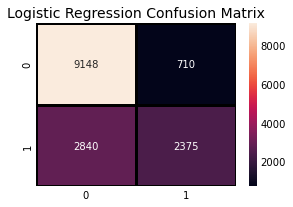

In [70]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Logistic Regression Confusion Matrix",fontsize=14)
plt.show()

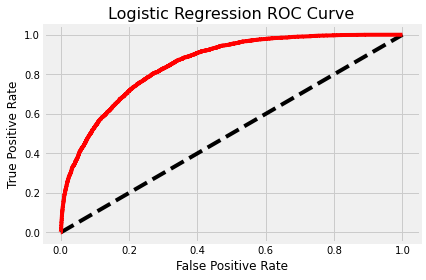

In [71]:
from sklearn.metrics import roc_curve
y_lgrpred_prob = clf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_lgrpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.show();

## Decision Tree

In [25]:
X = final_dataset[['customer_id', 'most_recent', 'payment_method', 'payment_status', 'promo_amount', 'monetary', 
                 'quantity', 'frequency', 'transaction_amount', 'age', 'promo_amount_used', 'total_amount_paid']]
y = final_dataset['is_churn']
# X = dataset2[['customer_id', 'payment_method', 'payment_status', 'promo_amount', 
#                  'quantity', 'age']]
# y = dataset2['is_churn']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)

In [27]:
# Fit Decision Tree Model
regr = DecisionTreeClassifier()
regr.fit(X_train, y_train)

# Predict
y_pred_dt = regr.predict(X_test)
regr.score(X_test, y_test)

0.9432760565249121

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_dt, y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      9811
           1       0.92      0.91      0.92      5262

    accuracy                           0.94     15073
   macro avg       0.94      0.94      0.94     15073
weighted avg       0.94      0.94      0.94     15073



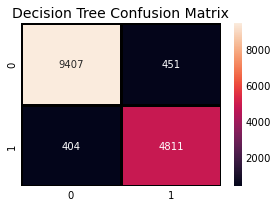

In [29]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred_dt),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Decision Tree Confusion Matrix",fontsize=14)
plt.show()

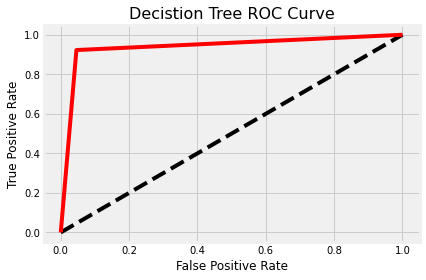

In [30]:
from sklearn.metrics import roc_curve
y_dtpred_prob = regr.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_dtpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Decistion Tree',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decistion Tree ROC Curve',fontsize=16)
plt.show();

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

X = final_dataset[['customer_id', 'most_recent', 'payment_method', 'payment_status', 'promo_amount', 'monetary', 
                 'quantity', 'frequency', 'transaction_amount', 'age', 'promo_amount_used', 'total_amount_paid']]
y = final_dataset['is_churn']
# X = dataset2[['customer_id', 'payment_method', 'payment_status', 'promo_amount', 
#                  'quantity', 'age']]
# y = dataset2['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)


# Fit Regression Model
rfc = RandomForestClassifier(max_depth=2)
rfc.fit(X_train, y_train)

# Predict
y_pred_rf = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.860412658395807

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_rf, y_test))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     11788
           1       0.61      0.97      0.75      3285

    accuracy                           0.86     15073
   macro avg       0.80      0.90      0.83     15073
weighted avg       0.91      0.86      0.87     15073



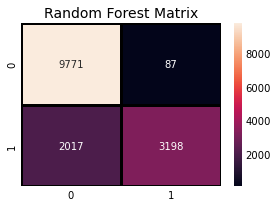

In [75]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Random Forest Matrix",fontsize=14)
plt.show()

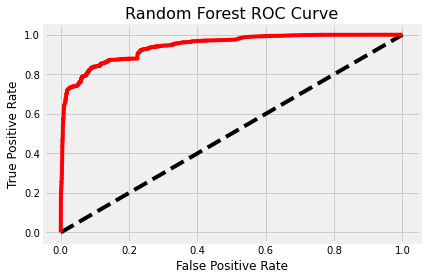

In [34]:
from sklearn.metrics import roc_curve
y_rfpred_prob = rfc.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();

# Hyper Tuning Paramaters

## Logistic Regression

In [76]:
#Logistic Regression
# Build the steps
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)

# Create the parameter space
parameters = {"logreg__C": np.logspace(-5, 8, 15),
              "logreg__class_weight": [dict, 'balanced'],
              "logreg__penalty": ['l1', 'l2', 'elasticnet', 'none']}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)


AUC Score : 0.9256446466818902 
 Best Paramaters: {'logreg__C': 1e-05, 'logreg__class_weight': <class 'dict'>, 'logreg__penalty': 'none'}


In [77]:
# Create the parameter space
parameters = {"logreg__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              "logreg__warm_start": [True, False],
              "logreg__fit_intercept": [True, False],
              "logreg__dual": [True, False]}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)
y_pred_rf = rfc.predict(X_test)

AUC Score : 0.925047486238259 
 Best Paramaters: {'logreg__dual': True, 'logreg__fit_intercept': True, 'logreg__solver': 'liblinear', 'logreg__warm_start': False}


In [74]:
model_new = LogisticRegression(C = 1e-05, class_weight = dict, penalty = 'none', 
                               dual = False, fit_intercept = True, solver = 'saga', 
                               warm_start = True)
model_new.fit(X_train, y_train)
model_new.predict(X_test)
model_new.score(X_test, y_test)

0.6540171166987329

In [38]:
y_pred_lgr = model_new.predict(X_test)
print(classification_report(y_pred_lgr, y_test))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84     11988
           1       0.46      0.77      0.57      3085

    accuracy                           0.76     15073
   macro avg       0.69      0.77      0.70     15073
weighted avg       0.83      0.76      0.78     15073



## Decision Tree

In [39]:
# DecisionTree
# Build the steps
steps = [("scaler", StandardScaler()),
         ("dt", DecisionTreeClassifier())]
pipeline = Pipeline(steps)

# Create the parameter space
paramdt2 = {
    'dt__max_depth': [2, 3, 5, 10, 20],
    'dt__min_samples_leaf': [5, 10, 20, 50, 100],
    'dt__criterion': ["gini", "entropy"]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=paramdt2)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)

AUC Score : 0.9579742981026003 
 Best Paramaters: {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 10}


In [40]:
# Decision Tree Param2 
# Create the parameter space
paramdt2 = {
    'dt__splitter': ["best", "random"],
    'dt__min_samples_split': [5, 10, 20, 50, 100],
    'dt__class_weight': [dict, "balanced"]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=paramdt2)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)

AUC Score : 0.9495862735086847 
 Best Paramaters: {'dt__class_weight': 'balanced', 'dt__min_samples_split': 50, 'dt__splitter': 'best'}


In [41]:
# Decision Tree Params 3
# Create the parameter space
paramdt3 = {
    'dt__max_features': ["auto", "sqrt", "log2"],
    'dt__min_weight_fraction_leaf': np.arange(0, 0.5),
  
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=paramdt3)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)

AUC Score : 0.9275214158558169 
 Best Paramaters: {'dt__max_features': 'sqrt', 'dt__min_weight_fraction_leaf': 0.0}


In [42]:
model_new2 = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 10)
model_new2.fit(X_train, y_train)
model_new2.predict(X_test)
model_new2.score(X_test, y_test)

0.9608571618125125

In [43]:
y_pred_dt = model_new2.predict(X_test)
print(classification_report(y_pred_dt, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10064
           1       0.92      0.96      0.94      5009

    accuracy                           0.96     15073
   macro avg       0.95      0.96      0.96     15073
weighted avg       0.96      0.96      0.96     15073



## Random Forest

In [44]:
# Random Forest
# Build the steps
steps = [("scaler", StandardScaler()),
         ("rfc", RandomForestClassifier())]
pipeline = Pipeline(steps)

# Create the parameter space
params1 = {
    'rfc__max_depth': [2, 3, 5, 10, 20],
    'rfc__min_samples_leaf': [5, 10, 20, 50, 100],
    'rfc__criterion': ["gini", "entropy"]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=params1)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)

AUC Score : 0.9595950622478757 
 Best Paramaters: {'rfc__criterion': 'entropy', 'rfc__max_depth': 20, 'rfc__min_samples_leaf': 5}


In [45]:
# Create the parameter space
params1 = {
    'rfc__max_features': ["sqrt", "log2", "auto", None],
    'rfc__bootstrap': [True, False],
    'rfc__oob_score': [True, False]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=params1)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)

AUC Score : 0.9597088198003636 
 Best Paramaters: {'rfc__bootstrap': True, 'rfc__max_features': 'log2', 'rfc__oob_score': False}


In [46]:
# Create the parameter space
params1 = {
    'rfc__warm_start': [True, False],
    'rfc__class_weight': ["balanced", "balanced_subsample"]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=100)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=params1)

# Fit to the training data
cv.fit(X_train, y_train)
print("AUC Score :",cv.best_score_, "\n","Best Paramaters:",cv.best_params_)

AUC Score : 0.9593675835284982 
 Best Paramaters: {'rfc__class_weight': 'balanced_subsample', 'rfc__warm_start': False}


In [47]:
model_new3 = RandomForestClassifier(criterion = 'gini', max_depth = 20, min_samples_leaf = 5, bootstrap = True,
                                   max_features = 'auto')
model_new3.fit(X_train, y_train)
model_new3.predict(X_test)
model_new3.score(X_test, y_test)

0.9615205997478936

In [48]:
y_pred_dt = model_new3.predict(X_test)
print(classification_report(y_pred_dt, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10060
           1       0.93      0.96      0.94      5013

    accuracy                           0.96     15073
   macro avg       0.95      0.96      0.96     15073
weighted avg       0.96      0.96      0.96     15073



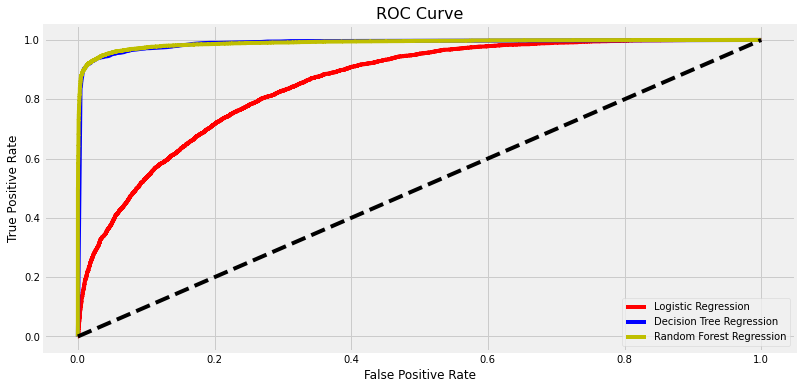

In [49]:
plt.figure(figsize = (12,6), linewidth= 1)
y_logreg = model_new.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_logreg)
plt.plot(fpr_rf, tpr_rf, label='Logistic Regression',color = "r")
y_dt = model_new2.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_dt)
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Regression',color = "b")
y_rf = model_new3.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest Regression',color = "y")
plt.plot([0, 1], [0, 1], 'k--' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve',fontsize=16)
plt.legend(loc='best')
plt.show()
# plt.plot(fpr_log_primal, tpr_log_primal, label = 'Logistic Regression: ' + str(round(roc_auc_rf, 5)))
# plt.plot(fpr_log_pol2, tpr_log_pol2, label = 'log pol2 score: ' + str(round(auc_log_pol2, 5)))
# plt.plot(fpr_SVM_RBF, tpr_SVM_RBF, label = 'SVM RBF Score: ' + str(round(auc_SVM_RBF, 5)))
# plt.plot(fpr_SVM_POL, tpr_SVM_POL, label = 'SVM POL Score: ' + str(round(auc_SVM_POL, 5)))
# plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
# plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 5)))
# plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC Curve')
# plt.legend(loc='best')
# #plt.savefig('roc_results_ratios.png')
# plt.show()

# Another Modelling (Tanpa RFM)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [51]:
!pip install lightgbm

In [52]:
!pip install catboost

In [53]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,plot_confusion_matrix,plot_roc_curve,roc_curve
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn import svm
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier


In [54]:
X = final_dataset[['customer_id', 'most_recent', 'payment_method', 'payment_status', 'promo_amount', 
                 'quantity', 'transaction_amount', 'age', 'promo_amount_used', 'total_amount_paid']]
y = final_dataset['is_churn']
# X = dataset2[['customer_id', 'payment_method', 'payment_status', 'promo_amount', 
#                  'quantity', 'age']]
# y = dataset2['is_churn']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)

In [56]:
print("Jumlah data training: ", X_train.shape)
print("Jumlah data testing: ", X_test.shape)

Jumlah data training:  (35169, 10)
Jumlah data testing:  (15073, 10)


In [57]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
#   "KNeighbors" : KNeighborsClassifier(),
#     "XGBoost" : XGBClassifier(max_depth=12,
#                               n_estimators=250,
#                               min_child_weight=8, 
#                               subsample=0.8, 
#                               learning_rate =0.02,    
#                               seed=42),
#     "CatBoost" : CatBoostClassifier(iterations=250,
#                            learning_rate=0.2,
#                            od_type='Iter',
#                            verbose=25,
#                            depth=16,
#                            random_seed=42)
 }

In [58]:
result_table = pd.DataFrame(columns=['classifiers','accuracy','presicion','recall','f1_score','fpr','tpr','auc'])

y_test = y_test.astype(int)

In [59]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    
    yproba = classifier.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    result_table = result_table.append({'classifiers':key,
                                        'accuracy':accuracy_score(y_test, y_predict),
                                        'presicion':precision_score(y_test, y_predict, average='weighted'),
                                        'recall':recall_score(y_test, y_predict, average='weighted'),
                                        'f1_score':f1_score(y_test, y_predict, average='weighted'),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc
                                         }, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)

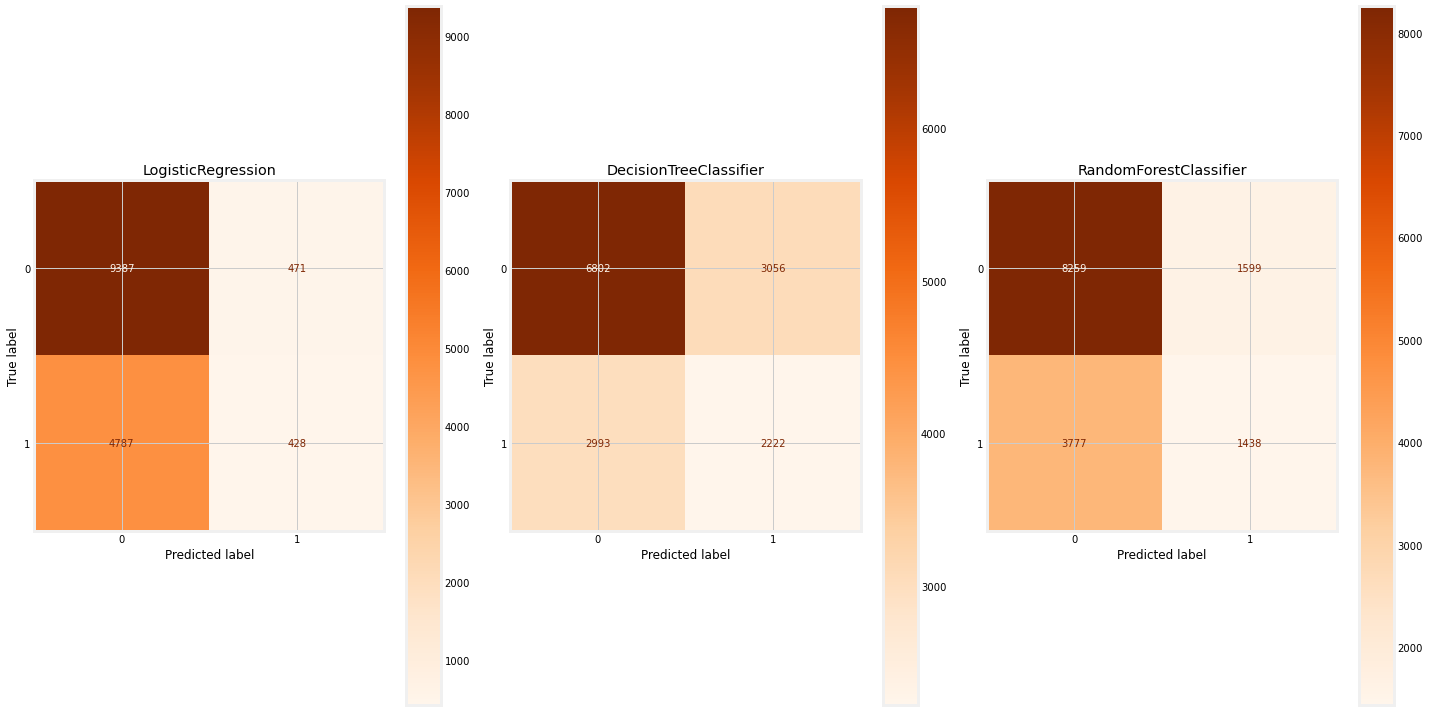

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))

for cls, ax in zip(list(classifiers.values()), axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Oranges')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

In [61]:
result_table.iloc[:,:4]

,accuracy,presicion,recall,f1_score
classifiers,,,,
LogisticRegression,0.651164,0.597852,0.651164,0.559364
DecisionTree,0.598686,0.599829,0.598686,0.599248
RandomForest,0.643336,0.612602,0.643336,0.614008


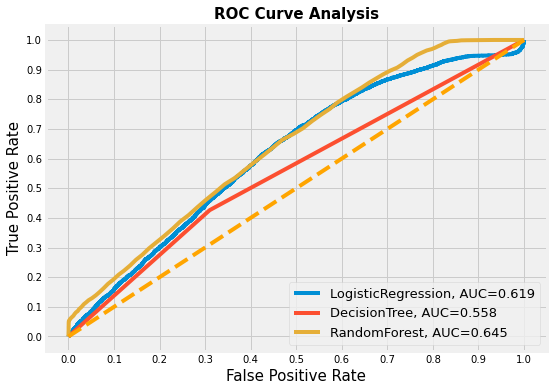

In [62]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()